# Feature Engineering with Fast cuDF-Pandas!
One of the most powerful feature engineering techniques is `groupby(COL1)[COL2].agg(STAT)`. This is where we group by `COL1` column and aggregate (i.e. compute) a statistic `STAT` over another column `COL2`. This is the underlying method to compute `target encoding` and `count encoding`. By computing raw statistics and inputting them into our model, our model can do more than only receiving `TE` or `CE`. This notebook illustrates creating 50 engineered features, but we can create hundreds more and improve CV score and LB score!

When our dataset has millions of rows like Kaggle's Backpack competition, then `groupby` operations take time to compute. The fastest way to compute a `groupby` aggregation is to use GPU with [RAPIDS cuDF-Pandas][1] library.

There are two ways to use [RAPIDS cuDF][2]. We can write cuDF code which looks just like Pandas code and starts with `import cudf`. Or we can write normal Pandas code with `import pandas` but before that we add the cell magic command `%load_ext cudf.pandas`. By adding this magic command all calls to Pandas afterward will use [RAPIDS cuDF][2] behind the scenes taking advantage of the massive speed boost of GPU!

Alternatively, we can use [cuDF-Polars][3]. To use [cuDF-Polars][3], we write Polars code with lazy frame. Then the final call includes `.collect(engine="gpu")` which will run all previous Polars code behind the scenes with [RAPIDS cuDF][2].

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://rapids.ai/polars-gpu-engine/

# RAPIDS v25.02
[RAPIDS v25.02][1] was just released Feb 15, 2025! Instructions on installing RAPIDS is [here][1]. On Kaggle, the easiest way to pip install new libraries is to do it once in a `Utility Script` notebook. Then whenever we attach the `Utility Script` notebook to another Kaggle notebook, the second Kaggle notebook immediately gets the benefit of the pip installed libraries. We created a [RAPIDS 25.02][1] `Utility Script` [here][2], and we attach it to the notebook you are reading. Therefore the notebook you are reading can import RAPIDS v25.02 without needing to pip install!

[1]: https://docs.rapids.ai/install/
[2]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

# GPU Acceleration
We activate [cuDF-Pandas][1] with the magic command `%load_ext cudf.pandas` below. Afterward, all calls to Pandas will use fast GPU [RAPIDS cuDF][2] behind the scenes! Since we attached `Utility Script` notebook [here][3] to the notebook you are reading, we will be using the new [RAPIDS v25.02][2]!

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

In [1]:

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

VER=1

# Load Data
We load train, train extra, and test data. The combined train data has 4 million rows! This means we do not need to fear overfitting train. We can make hundreds/thousands of new features and every time our CV improves our LB will improve too!

In [2]:
data = pd.read_csv("train.csv")
print("Train shape", data.shape )
data.head()

Train shape (1288, 17)


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,75516,1731.4840,411.7352,245.7620,0.8023,310.0806,0.9148,82546,0.7169,1.6753,0.3165,0.7531,0.0055,0.0033,0.5672,0.9502,1
1,98903,1374.4370,477.2451,269.7676,0.8249,354.8622,0.9585,103181,0.7679,1.7691,0.6579,0.7436,0.0048,0.0027,0.5529,0.9781,0
2,84746,1311.1570,482.7735,235.9040,0.8725,328.4843,0.9121,92914,0.7162,2.0465,0.6195,0.6804,0.0057,0.0028,0.4630,0.9474,1
3,98184,1463.1680,434.3769,292.6472,0.7390,353.5700,0.9543,102890,0.7316,1.4843,0.5763,0.8140,0.0044,0.0030,0.6625,0.9834,0
4,94170,1267.7271,440.1109,278.4162,0.7745,346.2672,0.9643,97656,0.6836,1.5808,0.7363,0.7868,0.0047,0.0030,0.6190,0.9785,0


In [3]:
from sklearn.model_selection import train_test_split
train, train2 = train_test_split(data, test_size=0.3)
print("Extra Train shape", train2.shape )
train2.head()

Extra Train shape (387, 17)


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
536,82463,2182.4021,444.5504,282.1806,0.7727,324.0295,0.8725,94513,0.6909,1.5754,0.2176,0.7289,0.0054,0.0034,0.5313,0.8370,0
699,68113,1826.5710,436.8805,215.2481,0.8702,294.4897,0.9100,74852,0.6598,2.0297,0.2565,0.6741,0.0064,0.0032,0.4544,0.9222,1
374,78094,1268.4580,446.7252,225.9483,0.8627,315.3290,0.9691,80585,0.7611,1.9771,0.6099,0.7059,0.0057,0.0029,0.4982,0.9851,1
915,87827,1204.8390,451.4225,257.9102,0.8207,334.4022,0.9469,92754,0.7119,1.7503,0.7603,0.7408,0.0051,0.0029,0.5487,0.9605,0
52,73027,1128.6600,437.4580,235.1980,0.8432,304.9276,0.9009,81059,0.7306,1.8600,0.7204,0.6970,0.0060,0.0032,0.4859,0.9037,0


In [4]:
train = pd.concat([train,train2],axis=0,ignore_index=True)
print("Combined Train shape", train.shape)

Combined Train shape (1288, 17)


In [5]:
test = pd.read_csv("test.csv")
print("Test shape", test.shape )
test.head()

Test shape (430, 16)


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
0,93313,1862.7260,447.1666,278.4893,0.7824,344.6880,0.9361,99678,0.7607,1.6057,0.3380,0.7708,0.0048,0.0030,0.5942,0.9541
1,78778,2159.5969,439.1004,240.0113,0.8374,316.7069,0.9340,84345,0.7265,1.8295,0.2123,0.7213,0.0056,0.0030,0.5202,0.9517
2,74757,1661.6720,441.6910,225.3914,0.8600,308.5183,0.9359,79873,0.7255,1.9597,0.3402,0.6985,0.0059,0.0030,0.4879,0.9561
3,88074,2199.8889,460.8836,283.3717,0.7886,334.8721,0.8709,101133,0.6922,1.6264,0.2287,0.7266,0.0052,0.0032,0.5279,0.8586
4,79318,2589.4900,429.3032,279.5817,0.7589,317.7905,0.8666,91528,0.6634,1.5355,0.1486,0.7402,0.0054,0.0035,0.5480,0.8414


# Feature Engineer Columns
We will engineer 8 new columns by combining existing columns.

In [93]:
CATS = ['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'eqdiasq', 'solidity', 'convex_area', 'extent', 'aspect_ratio', 'roundness', 'compactness', 'shapefactor_1', 'shapefactor_3','shapefactor_4']
print(f"There are 17 numerical column:")

There are 17 numerical column:


In [94]:
COMBO = []
for i,c in enumerate(CATS):
    #print(f"{c}, ",end="")
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)]
    test[c] = combine[len(train):]
    n = f"{c}_sf2"
    train[n] = train[c]*100 + train["shapefactor_2"]
    test[n] = test[c]*100 + test["shapefactor_2"]
    COMBO.append(n)
print()
print(f"We engineer {len(COMBO)} new columns!")
print( COMBO )


We engineer 15 new columns!
['area_sf2', 'perimeter_sf2', 'major_axis_sf2', 'minor_axis_sf2', 'eccentricity_sf2', 'eqdiasq_sf2', 'solidity_sf2', 'convex_area_sf2', 'extent_sf2', 'aspect_ratio_sf2', 'roundness_sf2', 'compactness_sf2', 'shapefactor_1_sf2', 'shapefactor_3_sf2', 'shapefactor_4_sf2']


In [6]:
FEATURES = CATS + ["shapefactor_2"] + COMBO
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )

NameError: name 'CATS' is not defined

In [7]:
FEATURES = ['area', 'perimeter', 'major_axis', 'minor_axis', 
                   'eccentricity', 'eqdiasq', 'solidity', 'convex_area', 'extent', 
                   'aspect_ratio', 'roundness', 'compactness', 'shapefactor_1', 
                   'shapefactor_2', 'shapefactor_3', 'shapefactor_4']
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )

We now have 16 columns:
['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'eqdiasq', 'solidity', 'convex_area', 'extent', 'aspect_ratio', 'roundness', 'compactness', 'shapefactor_1', 'shapefactor_2', 'shapefactor_3', 'shapefactor_4']


# XGBoost with Feature Engineer GroupBy
We train XGBoost with nested folds. We use the inner nested fold to create new features that aggregate the target `price`. And we use the outer fold to create new features that do not aggregate the target `price`. In each k fold loop, we engineer new features using the advanced feature engineering technique `groupby(COL1)[COL2].agg(STAT)`. Since we are using [RAPIDS cuDF-Pandas][1], these groupby computations will run fast on GPU! And we will train our model quickly on GPU using XGBoost!

[1]: https://rapids.ai/cudf-pandas/

In [8]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
print(f"XGBoost version",xgb.__version__)

XGBoost version 3.0.0


In [9]:
# STATISTICS TO AGGEGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","nunique","median","min","max","skew"]
STATS2 = ["mean","std"]

In [10]:
test[FEATURES]

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
0,93313,1862.7260,447.1666,278.4893,0.7824,344.6880,0.9361,99678,0.7607,1.6057,0.3380,0.7708,0.0048,0.0030,0.5942,0.9541
1,78778,2159.5969,439.1004,240.0113,0.8374,316.7069,0.9340,84345,0.7265,1.8295,0.2123,0.7213,0.0056,0.0030,0.5202,0.9517
2,74757,1661.6720,441.6910,225.3914,0.8600,308.5183,0.9359,79873,0.7255,1.9597,0.3402,0.6985,0.0059,0.0030,0.4879,0.9561
3,88074,2199.8889,460.8836,283.3717,0.7886,334.8721,0.8709,101133,0.6922,1.6264,0.2287,0.7266,0.0052,0.0032,0.5279,0.8586
4,79318,2589.4900,429.3032,279.5817,0.7589,317.7905,0.8666,91528,0.6634,1.5355,0.1486,0.7402,0.0054,0.0035,0.5480,0.8414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,82531,1237.1060,493.5974,224.9682,0.8901,324.1631,0.9297,88769,0.7260,2.1941,0.6777,0.6567,0.0060,0.0027,0.4313,0.9463
426,67632,1172.7740,450.7991,199.7804,0.8964,293.4480,0.9534,70939,0.6800,2.2565,0.6179,0.6510,0.0067,0.0030,0.4237,0.9562
427,85519,1200.8210,480.6819,240.4698,0.8659,329.9790,0.9254,92409,0.7129,1.9989,0.7453,0.6865,0.0056,0.0028,0.4713,0.9420
428,86261,1156.8521,456.5374,241.3351,0.8489,331.4075,0.9878,87326,0.6689,1.8917,0.8100,0.7259,0.0053,0.0028,0.5270,0.9968


In [13]:
%%time

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))
pred = np.zeros((len(test)))

# OUTER K FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train.loc[train_index,FEATURES+['target']].reset_index(drop=True).copy()
    y_train = train.loc[train_index,'target']

    X_valid = train.loc[test_index,FEATURES].reset_index(drop=True).copy()
    y_valid = train.loc[test_index,'target']

    X_test = test[FEATURES].reset_index(drop=True).copy()

    # INNER K FOLD (TO PREVENT LEAKAGE WHEN USING PRICE)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2,FEATURES+['target']].copy()
        X_valid2 = X_train.loc[test_index2,FEATURES].copy()
        
        ### FEATURE SET 1 (uses price) ###
        col = "shapefactor_2"
        tmp = X_train2.groupby(col).target.agg(STATS)
        tmp.columns = [f"TE1_shape2_{s}" for s in STATS]
        
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        
        for c in tmp.columns:
            X_train.loc[test_index2,c] = X_valid2[c].values
        

        #### FEATURE SET 2 (uses price) ###
        #for col in COMBO:
        #    tmp = X_train2.groupby(col).target.agg(STATS2)
        #    tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        #    X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        #    for c in tmp.columns:
        #        X_train.loc[test_index2,c] = X_valid2[c].values

    ### FEATURE SET 1 (uses price) ###
    col = "shapefactor_2"
    tmp = X_train.groupby(col).target.agg(STATS)
    tmp.columns = [f"TE1_shape2_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    #### FEATURE SET 2 (uses price) ###
    #for col in COMBO:
    #    tmp = X_train.groupby(col).target.agg(STATS2)
    #    tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
    #    X_valid = X_valid.merge(tmp, on=col, how="left")
    #    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 3 (does not use price) ###
    #for col in CATS:
    #    col2 = "shapefactor_2"
    #    tmp = X_train.groupby(col)[col2].agg(STATS2)
    #    tmp.columns = [f"FE3_{col}_sh2_{s}" for s in STATS2]
    #    X_train = X_train.merge(tmp, on=col, how="left")
    #    X_valid = X_valid.merge(tmp, on=col, how="left")
    #    X_test = X_test.merge(tmp, on=col, how="left")
#
    ## CONVERT TO CATS SO XGBOOST RECOGNIZES THEM
    #X_train[CATS] = X_train[CATS].astype("category")
    #X_valid[CATS] = X_valid[CATS].astype("category")
    #X_test[CATS] = X_test[CATS].astype("category")

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['target'],axis=1)

    # BUILD MODEL
    model = XGBRegressor(
        device="cuda",
        max_depth=6,  
        colsample_bytree=0.5, 
        subsample=0.8,  
        n_estimators=10_000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=100,
    )
    
    # TRAIN MODEL
    COLS = X_train.columns
    model.fit(
        X_train[COLS], y_train,
        eval_set=[(X_valid[COLS], y_valid)],  
        verbose=300,
    )

    # PREDICT OOF AND TEST
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

pred /= FOLDS

### OUTER Fold 1 ###
 ## INNER Fold 1 (outer fold 1) ##
 ## INNER Fold 2 (outer fold 1) ##
 ## INNER Fold 3 (outer fold 1) ##
 ## INNER Fold 4 (outer fold 1) ##
 ## INNER Fold 5 (outer fold 1) ##
 ## INNER Fold 6 (outer fold 1) ##
 ## INNER Fold 7 (outer fold 1) ##
[0]	validation_0-rmse:0.48356
[227]	validation_0-rmse:0.32439
### OUTER Fold 2 ###
 ## INNER Fold 1 (outer fold 2) ##
 ## INNER Fold 2 (outer fold 2) ##
 ## INNER Fold 3 (outer fold 2) ##
 ## INNER Fold 4 (outer fold 2) ##
 ## INNER Fold 5 (outer fold 2) ##
 ## INNER Fold 6 (outer fold 2) ##
 ## INNER Fold 7 (outer fold 2) ##
[0]	validation_0-rmse:0.48646


c:\Users\ilyav\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [18:19:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[219]	validation_0-rmse:0.32666
### OUTER Fold 3 ###
 ## INNER Fold 1 (outer fold 3) ##
 ## INNER Fold 2 (outer fold 3) ##
 ## INNER Fold 3 (outer fold 3) ##
 ## INNER Fold 4 (outer fold 3) ##
 ## INNER Fold 5 (outer fold 3) ##
 ## INNER Fold 6 (outer fold 3) ##
 ## INNER Fold 7 (outer fold 3) ##
[0]	validation_0-rmse:0.48562
[276]	validation_0-rmse:0.30236
### OUTER Fold 4 ###
 ## INNER Fold 1 (outer fold 4) ##
 ## INNER Fold 2 (outer fold 4) ##
 ## INNER Fold 3 (outer fold 4) ##
 ## INNER Fold 4 (outer fold 4) ##
 ## INNER Fold 5 (outer fold 4) ##
 ## INNER Fold 6 (outer fold 4) ##
 ## INNER Fold 7 (outer fold 4) ##
[0]	validation_0-rmse:0.49381
[300]	validation_0-rmse:0.30417
[522]	validation_0-rmse:0.30130
### OUTER Fold 5 ###
 ## INNER Fold 1 (outer fold 5) ##
 ## INNER Fold 2 (outer fold 5) ##
 ## INNER Fold 3 (outer fold 5) ##
 ## INNER Fold 4 (outer fold 5) ##
 ## INNER Fold 5 (outer fold 5) ##
 ## INNER Fold 6 (outer fold 5) ##
 ## INNER Fold 7 (outer fold 5) ##
[0]	validation

# Overall CV Score
Below we display overall cv score and save oof predictions to disk so we can use them later to assist finding ensemble weights with our other models.

In [14]:
# COMPUTE OVERALL CV SCORE
true = train.target.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")

=> Overall CV Score = 0.31684610539124236


In [15]:
# SAVE OOF TO DISK FOR ENSEMBLES
np.save(f"oof_v{VER}",oof)
print("Saved oof to disk")

Saved oof to disk


# Feature Names
Below we list all our engineered features. We are using 57 features in total!

In [16]:
print(f"\nIn total, we used {len(COLS)} features, Wow!\n")
print( list(COLS) )


In total, we used 24 features, Wow!

['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'eqdiasq', 'solidity', 'convex_area', 'extent', 'aspect_ratio', 'roundness', 'compactness', 'shapefactor_1', 'shapefactor_2', 'shapefactor_3', 'shapefactor_4', 'TE1_shape2_mean', 'TE1_shape2_std', 'TE1_shape2_count', 'TE1_shape2_nunique', 'TE1_shape2_median', 'TE1_shape2_min', 'TE1_shape2_max', 'TE1_shape2_skew']


# XGB Feature Importance
Here is XGBoost feature importance sorted by `gain`.

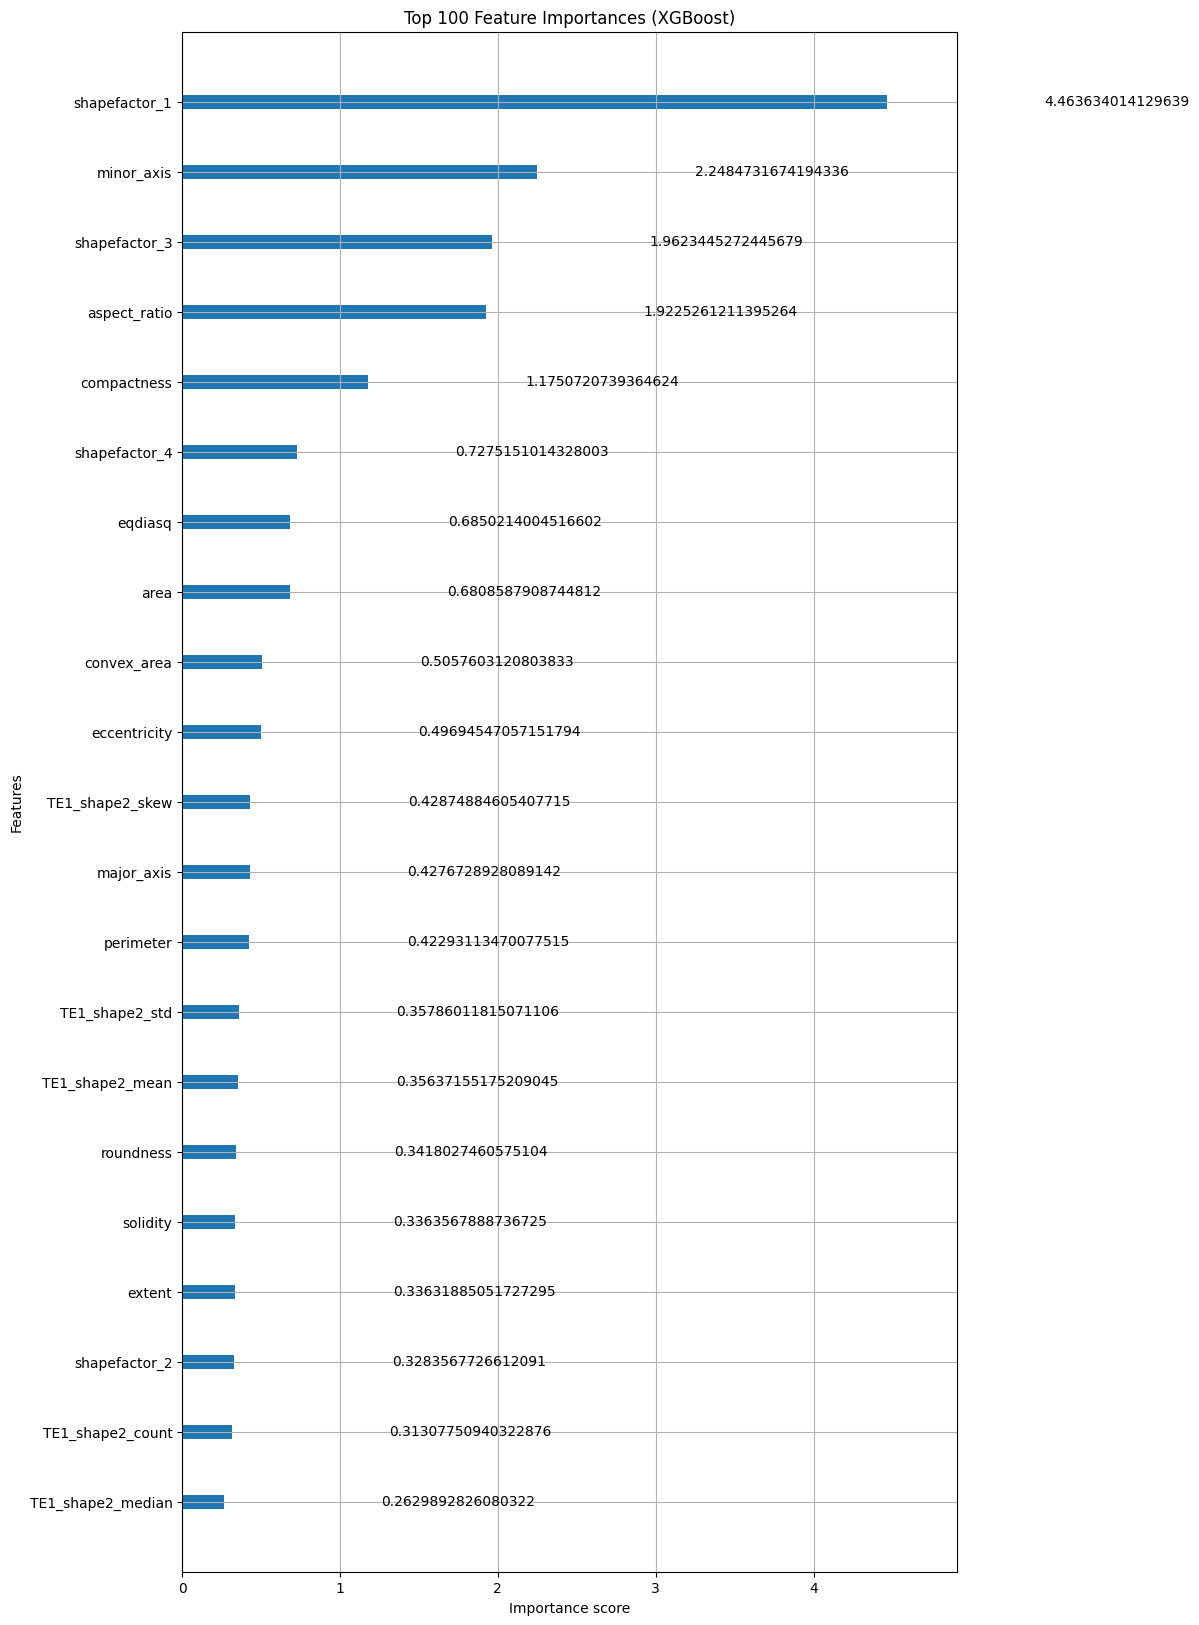

In [17]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, max_num_features=100, importance_type='gain',ax=ax)
plt.title("Top 100 Feature Importances (XGBoost)")
plt.show()

# Make Submission CSV
We save our test predictions to submission.csv and plot our predictions. 

In [16]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission_v{VER}.csv",index=False)
sub.head()

,id,Price
0,300000,79.935581
1,300001,83.089314
2,300002,86.401968
3,300003,76.810952
4,300004,79.446623


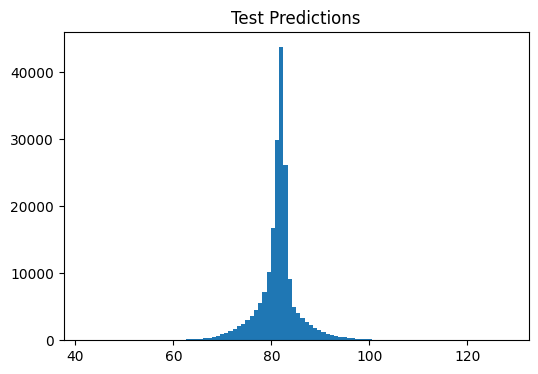

In [17]:
plt.figure(figsize=(6,4))
plt.hist(sub.Price,bins=100)
plt.title("Test Predictions")
plt.show()